# Inference of parameters (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.


In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [16]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

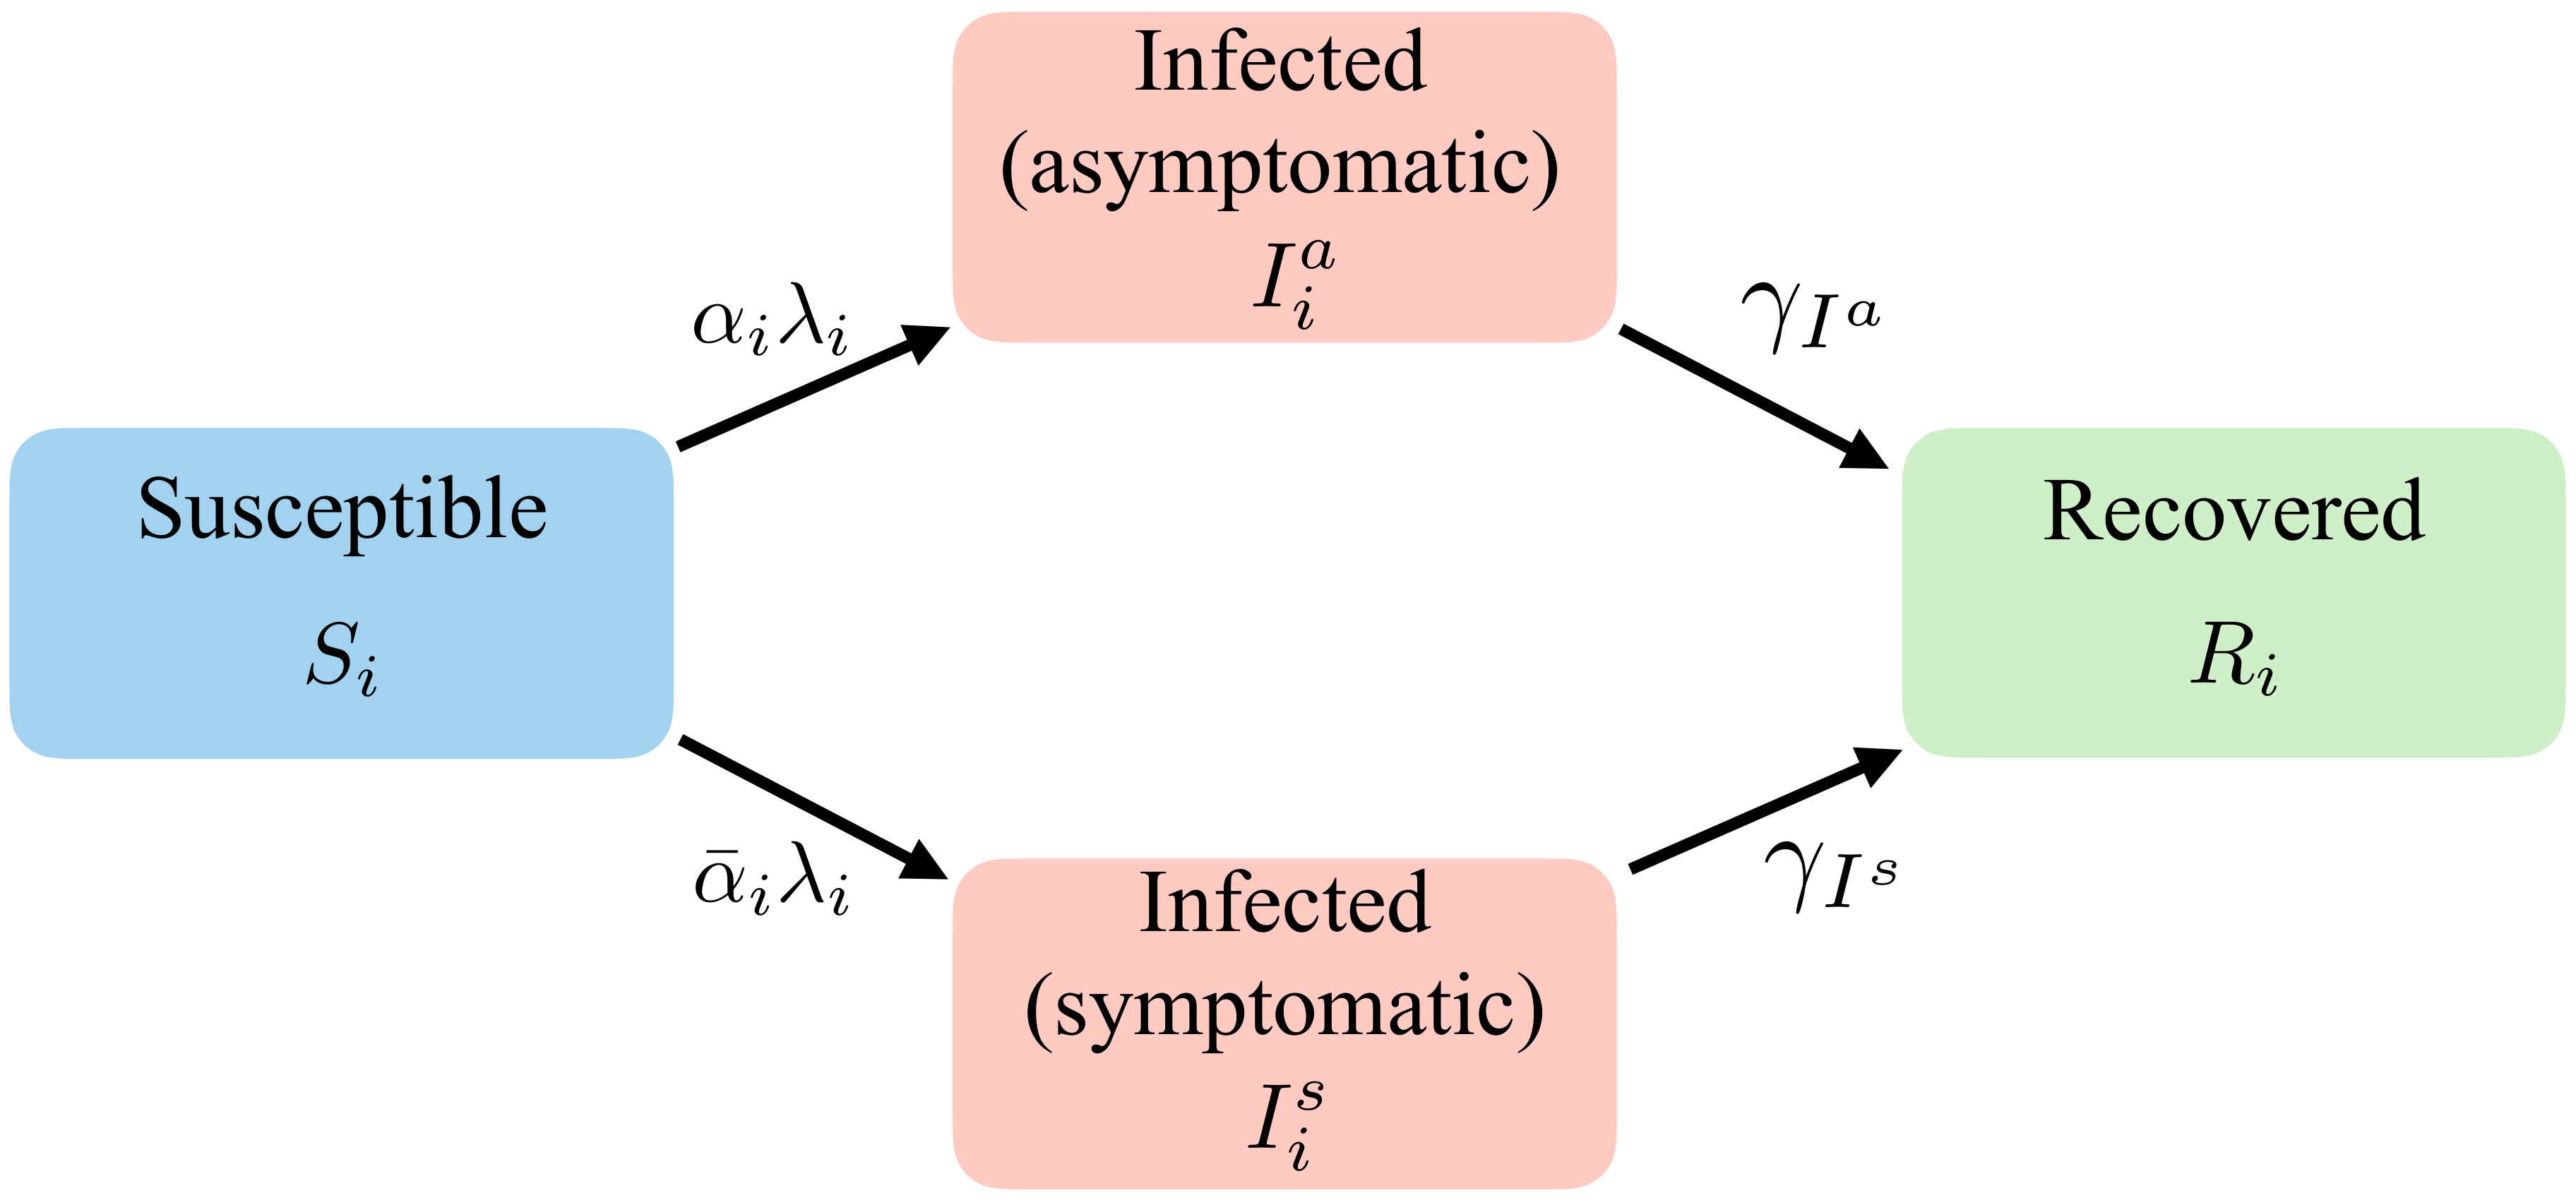

In [3]:
from IPython.display import Image
Image('SIIR.jpg')

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [21]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# parameters for generating synthetic trajectory 
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
# C_ij = number of people group from group i that an individual from group j meets per day 

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

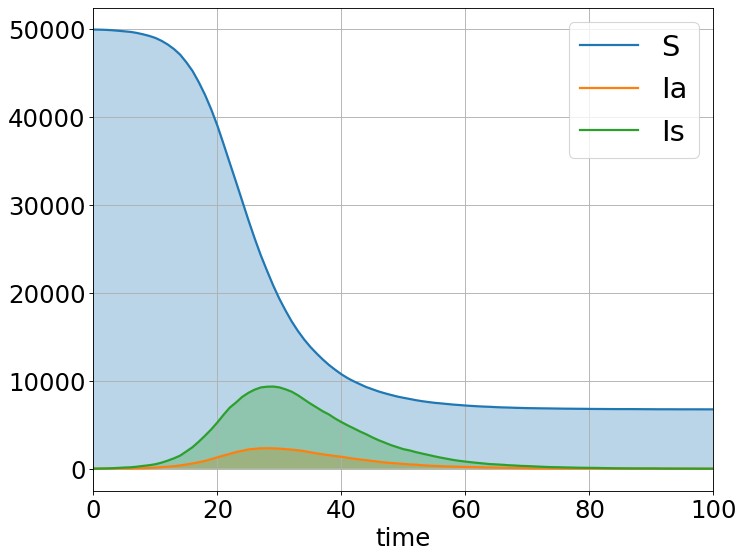

In [22]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the trajectories and use it to infer the parameters of the model.

In [23]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken, must be an odd number 

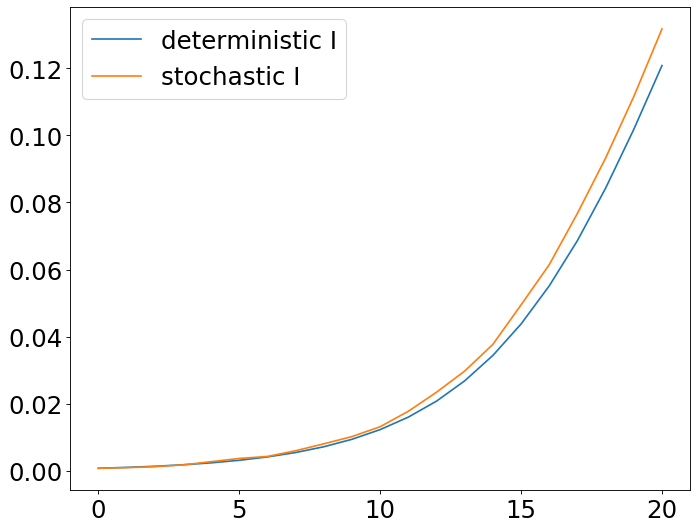

In [24]:
# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
x0=x[0]
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(xm[:, M:], axis=1), label='deterministic I')
plt.plot(np.sum(x[:Nf_inference, M:], axis=1), label='stochastic I')
plt.legend()
plt.show()

In [25]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-896.9206767794077
0.276900053024292


In [26]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.3
beta_g = 0.04
gIa_g = 0.1
gIs_g = 0.1


# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
print(logp) 

1757.7248924182452


In [27]:
# the names of the parameters to be inferred 
keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.1
gIs_std = 0.1
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

eps = 1e-4
# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6  
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    global_max_iter=20,
                                    local_max_iter=200, 
                                    global_ftol_factor=1e3, 
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=3985746892, Fri May 15 11:17:29 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 4.930223315367640e+02 1.0e+00 9.99e-01  1e-01  2e-01 0:03.6
    2     32 -5.736170201982875e+02 1.3e+00 9.07e-01  9e-02  1e-01 0:06.6
    3     48 1.032629029798104e+03 1.6e+00 8.52e-01  8e-02  1e-01 0:09.3
    4     64 -5.732517117797681e+02 1.5e+00 7.39e-01  6e-02  1e-01 0:12.7
    6     96 -6.943975938414470e+02 1.4e+00 5.70e-01  4e-02  9e-02 0:17.6
   10    160 -1.030798784686243e+02 2.3e+00 4.34e-01  2e-02  6e-02 0:24.8
   12    192 -6.428667408752077e+02 2.1e+00 4.19e-01  2e-02  5e-02 0:31.3
   15    240 -8.987222171266764e+02 3.1e+00 3.58e-01  1e-02  4e-02 0:39.9
   19    304 -8.983120621627917e+02 8.5e+00 3.14e-01  4e-03  4e-02 0:47.9
Optimal value (global minimisation):  -898.7222171266764
Starting local minimisation...
Optimal value (local minimisation):  -901.9841041

In [13]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = estimator.fill_params_dict(keys, params)
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-906.0925899273935
0.1885368824005127


In [28]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

Inferred parameters:
{'alpha': 0.21947462463547673, 'beta': 0.0199212954637395, 'gIa': 0.17497804782834045, 'gIs': 0.13375481787386112, 'fsa': 1}


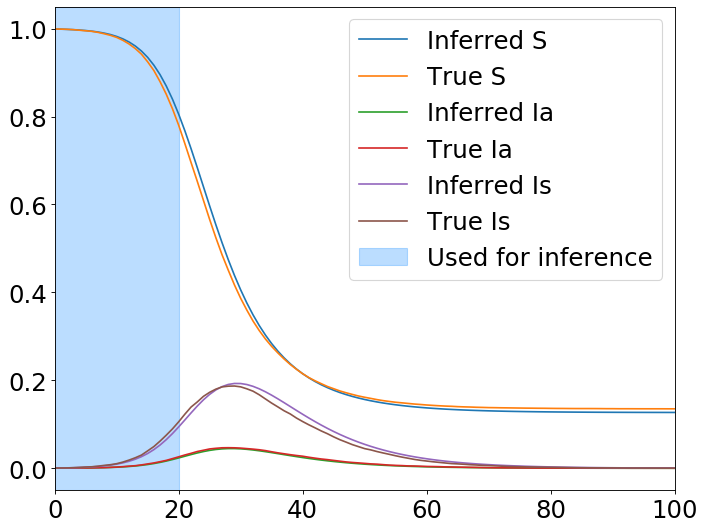

In [29]:
x = np.load('SIR_sto_traj.npy').astype('float')/N 
Nf = x.shape[0]
Tf = Nf-1

det_model = pyross.deterministic.SIR(new_parameters, int(M), fi)
x_det = estimator.integrate(x[0], 0, Tf, Nf, det_model, contactMatrix)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Is')
plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 